In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
example_dataset = pd.read_csv("data/Titanic-Dataset.csv")
example_dataset["Cabin"] = example_dataset["Cabin"].apply(lambda x: 1 if x != 0 else 0)
example_dataset = example_dataset.drop(
    columns=["PassengerId", "Cabin", "Name", "SibSp", "Parch", "Ticket"]
)
example_dataset["Embarked"] = example_dataset["Embarked"].factorize()[0]
example_dataset["Sex"] = example_dataset["Sex"].factorize()[0]
example_dataset.fillna(example_dataset["Age"].median(), inplace=True)
example_dataset

,Survived,Pclass,Sex,Age,Fare,Embarked
0,0,3,0,22.0,7.2500,0
1,1,1,1,38.0,71.2833,1
2,1,3,1,26.0,7.9250,0
3,1,1,1,35.0,53.1000,0
4,0,3,0,35.0,8.0500,0
...,...,...,...,...,...,...
886,0,2,0,27.0,13.0000,0
887,1,1,1,19.0,30.0000,0
888,0,3,1,28.0,23.4500,0
889,1,1,0,26.0,30.0000,1


# Confusion Matrix

In [33]:
def generate_graph_form_adjecency_matrix(
    adjacency_matrix: np.ndarray, mylabels: list[str], connection_cutoff: float = 0.3
) -> nx.Graph:
    rows, cols = np.where(abs(adjacency_matrix) >= connection_cutoff)
    graph = nx.Graph()
    all_rows = range(0, adjacency_matrix.shape[0])
    for n in all_rows:
        graph.add_node(mylabels[n])
    for row, column in zip(rows, cols):
        weight = adjacency_matrix[row, column]
        graph.add_edge(mylabels[row], mylabels[column], weight=weight)
    nx.draw(
        graph,
        node_size=900,
        labels={label: label for label in mylabels},
        with_labels=True,
    )
    plt.show()
    return graph

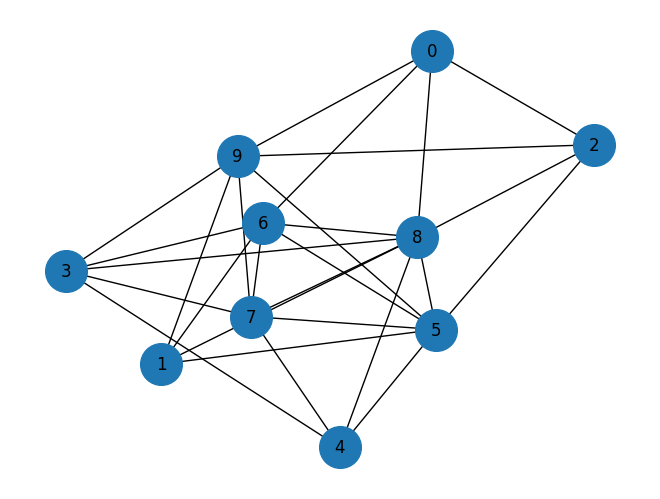

Graph Graph with 10 nodes and 27 edges


In [4]:
N = 10
example_correlation_matrix = np.random.random(size=(N, N))
example_correlation_matrix = (
    example_correlation_matrix + example_correlation_matrix.T
) / 2
np.fill_diagonal(example_correlation_matrix, 0.0)

graph = generate_graph_form_adjecency_matrix(
    example_correlation_matrix,
    mylabels={i: str(i) for i in range(N)},
    connection_cutoff=0.5,
)
print("Graph", graph)

In [5]:
def generate_basic_order_ofcolumns(
    correlation_matrix: pd.DataFrame, correlation_treshold: int = 0.2
) -> pd.DataFrame:
    correlation_matrix = abs(correlation_matrix)
    mask = correlation_matrix < correlation_treshold
    correlation_matrix[mask] = 0.0
    np.fill_diagonal(correlation_matrix.values, 0.0)
    return (
        pd.DataFrame(
            {
                "count": (correlation_matrix > 0).sum(),
                "max": correlation_matrix.max(),
                "min": correlation_matrix.mask(correlation_matrix <= 0).min(),
                "sum": correlation_matrix.sum(),
            }
        )
        .fillna(0)
        .sort_values(by=["count", "max", "min", "sum"])
    )


correlation_matrix_stats = generate_basic_order_ofcolumns(example_dataset.corr())
print("Correlation matrix stats:\n", correlation_matrix_stats)
print("Order of collumns:", correlation_matrix_stats.index.tolist())

Correlation matrix stats:
           count       max       min       sum
Embarked      0  0.000000  0.000000  0.000000
Age           1  0.339898  0.339898  0.339898
Sex           1  0.543351  0.543351  0.543351
Fare          2  0.549500  0.257307  0.806806
Survived      3  0.543351  0.257307  1.139139
Pclass        3  0.549500  0.338481  1.227879
Order of collumns: ['Embarked', 'Age', 'Sex', 'Fare', 'Survived', 'Pclass']


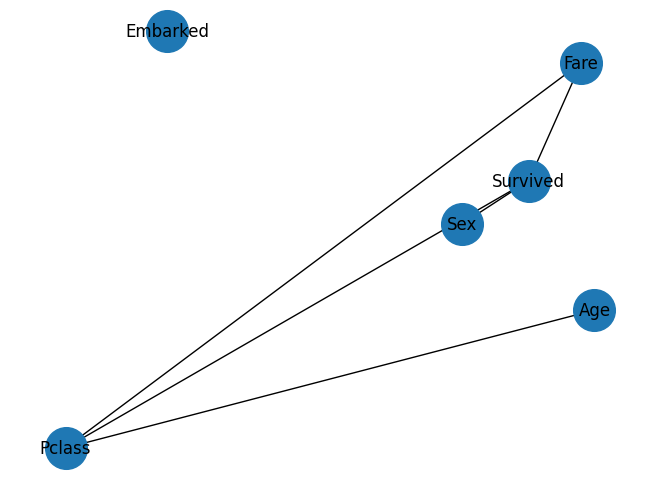

array([[ 0.        , -0.33848104,  0.54335138, -0.06491042,  0.25730652,
         0.10184882],
       [-0.33848104,  0.        , -0.13190049, -0.33989833, -0.54949962,
         0.05099176],
       [ 0.54335138, -0.13190049,  0.        , -0.08116254,  0.18233283,
         0.11124902],
       [-0.06491042, -0.33989833, -0.08116254,  0.        ,  0.09668842,
        -0.0146988 ],
       [ 0.25730652, -0.54949962,  0.18233283,  0.09668842,  0.        ,
         0.05846241],
       [ 0.10184882,  0.05099176,  0.11124902, -0.0146988 ,  0.05846241,
         0.        ]])

In [6]:
confusion_matrix = example_dataset.corr().to_numpy()
np.fill_diagonal(confusion_matrix, 0.0)
graph = generate_graph_form_adjecency_matrix(
    confusion_matrix, mylabels=example_dataset.columns.tolist(), connection_cutoff=0.2
)
confusion_matrix

# Random Forest

In [7]:
def get_feature_importance_order_random_forest(dataset: pd.DataFrame, ascending=True) -> list[str]:
    feature_importances = np.zeros(len(dataset.columns))

    for i, feature in enumerate(dataset.columns):
        if dataset[feature].dtype == "int64":
            rf = RandomForestClassifier()
        else:
            rf = RandomForestRegressor()
        rf.fit(dataset.drop(feature, axis=1), dataset[feature])
        idx_to_update = list(range(i)) + list(range(i + 1, len(dataset.columns)))
        feature_importances[idx_to_update] += rf.feature_importances_
    return list(reversed(dataset.columns[np.argsort(feature_importances)[::-1]].to_list())) if ascending else dataset.columns[np.argsort(feature_importances)].to_list()

In [8]:
print("Feature importance order by random forest:")
feature_importance_order = get_feature_importance_order_random_forest(example_dataset)
print(feature_importance_order)

Feature importance order by random forest:
['Embarked', 'Survived', 'Sex', 'Pclass', 'Age', 'Fare']


# Graph + confusion matrix

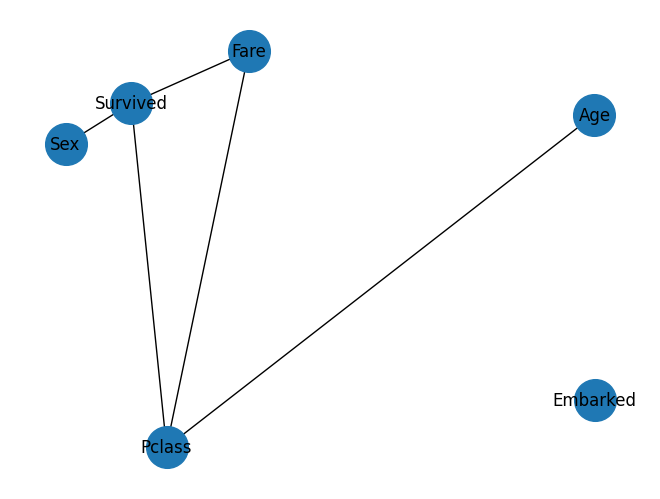

Visited nodes: ['Embarked', 'Age', 'Pclass', 'Fare', 'Survived', 'Sex']


In [50]:
confusion_matrix = example_dataset.corr().to_numpy()
np.fill_diagonal(confusion_matrix, 0.0)
graph = generate_graph_form_adjecency_matrix(
    confusion_matrix, mylabels=example_dataset.columns.tolist(), connection_cutoff=0.2
)
correlation_matrix_stats = list(reversed(generate_basic_order_ofcolumns(example_dataset.corr()).index.tolist()))
start_of_search = correlation_matrix_stats.pop()
visited_nodes = []
while len(visited_nodes) != len(graph.nodes):
    if start_of_search in visited_nodes:
        start_of_search = correlation_matrix_stats.pop()
        continue
    visited_nodes.append(start_of_search)
    if len(graph[start_of_search]) == 0:
        start_of_search = correlation_matrix_stats.pop()
        continue
    not_visited = set(graph[start_of_search].keys()) - set(visited_nodes)

    sorted_importance = sorted(list(not_visited), key=lambda x: abs(graph[start_of_search][x]["weight"]), reverse=True)
    if not sorted_importance:
        start_of_search = correlation_matrix_stats.pop()
        continue
    start_of_search = sorted_importance[0]
print("Visited nodes:", visited_nodes)


In [ ]:
# First
['Embarked', 'Age', 'Sex', 'Fare', 'Survived', 'Pclass']
# Second
['Embarked', 'Survived', 'Sex', 'Pclass', 'Age', 'Fare']
# Third
['Embarked', 'Age', 'Pclass', 'Fare', 'Survived', 'Sex']